# Кодирование и обучение в спайковых нейронных сетях
В этой домашней работе нужно сравнить две способа кодирования информации: частотный и временной.

## Задание
* Сгенерируйте обучающую и тестовую выборки простых изображений размером 3 на 3 пикселя
* Реализуйте два типа кодирования: частотой спайков и временем до первого спайка (TTFS). Использовать ноутбук к семинару про кодирование.  
* Обучите две сети по правилу STDP. Архитектуру сети можно взять из семинара по классификации. Вероятно, придется выбрать разные значения параметров для правила STDP.
* Сравните качество классификации по метрикам accuracy и F-measure

## References

[1] Diehl, P. U., & Cook, M. (2015). Unsupervised learning of digit recognition using spike-timing-dependent plasticity. Frontiers in computational neuroscience, 9, 99 

[2] https://www.kaggle.com/code/dlarionov/mnist-spiking-neural-network/notebook

# Libs

In [1]:
!pip install --upgrade pip

In [2]:
!pip install --upgrade setuptools

In [3]:
!pip install ez_setup

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
!pip install jupyter_contrib_nbextensions

In [6]:
import random

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

In [8]:
!pip install brian2
!pip install --upgrade numpy
!pip install --upgrade matplotlib

In [9]:
from brian2 import *
import brian2.numpy_ as np
import matplotlib.pyplot as plt

In [10]:
from sklearn.model_selection import train_test_split
import brian2 as b2

In [11]:
%matplotlib inline

In [12]:
import time

In [25]:
from scipy.stats import kstest
from sklearn import preprocessing
import scipy.stats as stats
from scipy.stats import normaltest

## 1. Генерация изображений


In [13]:
def draw_patterns(patterns):
  fig, ax = plt.subplots(nrows = 1, ncols = len(patterns), figsize=(10,5))
  for i,p in enumerate(patterns):
    ax[i].imshow(patterns[i], cmap='Greys')
    ax[i].tick_params(axis='both', labelbottom=False, labeltop=False, labelleft=False, labelright=False,
                             bottom=False, top=False, left=False, right=False)

In [14]:
t1 = np.array([[randint(0,2) for _ in range(3)] for _ in range(3)]).reshape(3,3)

for row in t1: 
    for item in row:
        print(item,end=" ") 
    print()
print("")

1 1 1 
0 1 0 
1 1 0 



In [15]:
t2 = np.array([[randint(0,2) for _ in range(3)] for _ in range(3)]).reshape(3,3)


for row in t2: 
    for item in row:
        print(item,end=" ") 
    print()
print("")

0 1 0 
0 0 0 
1 1 0 



In [16]:
t3 = np.array([[randint(0,2) for _ in range(3)] for _ in range(3)]).reshape(3,3)


for row in t3: 
    for item in row:
        print(item,end=" ") 
    print()
print("")

1 1 0 
1 1 1 
0 1 0 



In [17]:
t4 = np.array([[randint(0,2) for _ in range(3)] for _ in range(3)]).reshape(3,3)



for row in t4: 
    for item in row:
        print(item,end=" ") 
    print()
print("")

0 0 0 
0 1 0 
0 0 0 



In [18]:
t5 = np.array([[randint(0,2) for _ in range(3)] for _ in range(3)]).reshape(3,3)


for row in t5: 
    for item in row:
        print(item,end=" ") 
    print()
print("")

0 0 1 
1 0 1 
1 1 0 



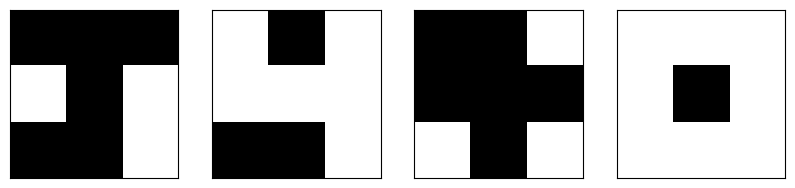

In [53]:
patterns = [t1, t2, t3, t4]
draw_patterns(patterns)

### Генерация обучающей и тестовой выборки


#### Для генерации выборки добавим шум


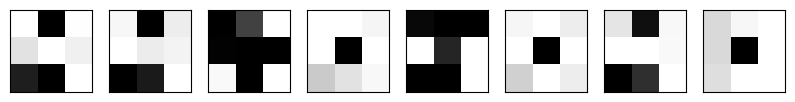

In [54]:
from sklearn.model_selection import train_test_split
N_SAMPLE_CLASS = 30
rng = np.random.default_rng()
X,y = [],[]
sigma = 0.15
for i_p,p in enumerate(patterns):
      for _ in range(N_SAMPLE_CLASS):
        X += [np.clip(p + sigma*rng.standard_normal(p.shape),0,1)]
        y += [i_p]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
draw_patterns(X_train[-8:])

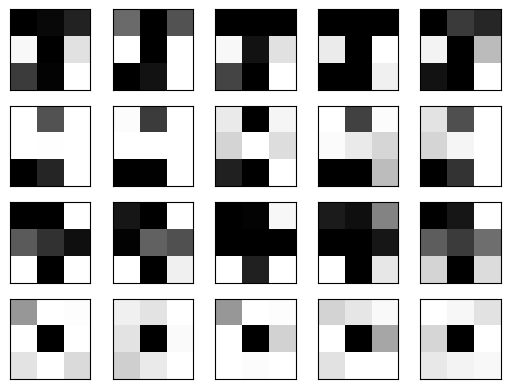

In [55]:
N_SAMPLE_CLASS = 20
rng = np.random.default_rng()
sample = []
sigma = 0.2
for _,p in enumerate(patterns):
  for i in range(N_SAMPLE_CLASS):
    sample += [np.clip(p + sigma*rng.standard_normal(p.shape),0,1)]
fig,axes = plt.subplots(len(patterns),5)
plt.tick_params(axis='both', bottom=False, top=False, left=False, right=False)
for ip in range(len(patterns)):
  for ix in range(5):
    axes[ip][ix].imshow(sample[ix+ip*N_SAMPLE_CLASS], cmap="Greys")
    axes[ip][ix].tick_params(axis='both', labelbottom=False, labeltop=False, labelleft=False, labelright=False,
                             bottom=False, top=False, left=False, right=False)

In [56]:
samplee = sample

In [57]:
sample


[array([[1.        , 0.97316198, 0.89328298],
        [0.15626919, 1.        , 0.29003041],
        [0.82871017, 0.98682192, 0.10473414]]),
 array([[0.65682209, 1.        , 0.74863607],
        [0.        , 1.        , 0.        ],
        [1.        , 0.93740788, 0.        ]]),
 array([[1.        , 1.        , 1.        ],
        [0.05603061, 0.93638548, 0.20523196],
        [0.78644236, 1.        , 0.        ]]),
 array([[1.        , 1.        , 1.        ],
        [0.1516454 , 1.        , 0.        ],
        [1.        , 1.        , 0.11756789]]),
 array([[1.        , 0.81500216, 0.86821836],
        [0.09375277, 1.        , 0.3797718 ],
        [0.93535006, 1.        , 0.        ]]),
 array([[1.        , 0.73069391, 1.        ],
        [0.        , 0.88531132, 0.        ],
        [1.        , 1.        , 0.35843205]]),
 array([[1.        , 1.        , 1.        ],
        [0.        , 1.        , 0.        ],
        [0.88855284, 0.74785837, 0.35417516]]),
 array([[0.65410464,

# 2. Реализуйте два типа кодирования: частотой спайков и временем до первого спайка (TTFS). 

### Частотное кодирование
Яркость пикселя $r_i$ преобразуется в частоту спайков
$$
\lambda_i=r_i\lambda_{max}
$$

### Временное кодирование TTFS
Яркость пикселя $r_i$ преобразуется во время спайка по правилу

$$
t_i=1/r_i
$$

# 3. Обучите две сети по правилу STDP. 

Архитектуру сети можно взять из семинара по классификации.

Вероятно, придется выбрать разные значения параметров для правила STDP.

## 3.1

In [84]:
num_input = patterns[0].size # input layer
input_group = b2.PoissonGroup(num_input, rates=np.zeros(num_input)*b2.Hz)
n_e = 100 # e - excitatory
n_i = n_e # i - inhibitory

v_rest_e = -5.*b2.mV # v - membrane potential
v_reset_e = -5.*b2.mV
v_thresh_e = -4.*b2.mV

v_rest_i = -50.*b2.mV
v_reset_i = -35.*b2.mV
v_thresh_i = -30.*b2.mV

taupre = 2*b2.ms
taupost = taupre
gmax = .015 #.05
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax 
dApre *= gmax 


In [85]:
# Apre and Apost - presynaptic and postsynaptic traces, lr - learning rate
stdp='''w : 1
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)'''
pre='''ge += w
    Apre += dApre
    w = clip(w + lr*Apost, 0, gmax)'''
post='''Apost += dApost
    w = clip(w + lr*Apre, 0, gmax)'''

In [86]:
debug=True

app = {}
        

app['PG'] = b2.PoissonGroup(num_input, rates=np.zeros(num_input)*b2.Hz, name='PG')

# excitatory group
neuron_e = '''
    dv/dt = (ge*(0*mV-v) + gi*(-100*mV-v) + (v_rest_e-v)) / (100*ms) : volt
    dge/dt = -ge / (5*ms) : 1
    dgi/dt = -gi / (10*ms) : 1
    '''
app['EG'] = b2.NeuronGroup(n_e, neuron_e, threshold='v>v_thresh_e', refractory=5*b2.ms, reset='v=v_reset_e', method='euler', name='EG')
app['EG'].v = v_rest_e - 20.*b2.mV

if (debug):
    app['ESP'] = SpikeMonitor(app['EG'], name='ESP')
    app['ESM'] = StateMonitor(app['EG'], ['v'], record=True, name='ESM')
    app['ERM'] = PopulationRateMonitor(app['EG'], name='ERM')

# ibhibitory group
neuron_i = '''
    dv/dt = (ge*(0*mV-v) + (v_rest_i-v)) / (10*ms) : volt
    dge/dt = -ge / (5*ms) : 1
    '''
app['IG'] = b2.NeuronGroup(n_i, neuron_i, threshold='v>v_thresh_i', refractory=2*b2.ms, reset='v=v_reset_i', method='euler', name='IG')
app['IG'].v = v_rest_i - 20.*b2.mV

if (debug):
    app['ISP'] = SpikeMonitor(app['IG'], name='ISP')
    app['ISM'] = StateMonitor(app['IG'], ['v'], record=True, name='ISM')
    app['IRM'] = PopulationRateMonitor(app['IG'], name='IRM')
        

    
# poisson generators one-to-all excitatory neurons with plastic connections 
app['S1'] = b2.Synapses(app['PG'], app['EG'], stdp, on_pre=pre, on_post=post, method='euler', name='S1')
app['S1'].connect()
app['S1'].w = 'rand()*gmax' # random weights initialisation
app['S1'].lr = 1 # enable stdp        

if (debug):
            # some synapses
    app['S1M'] = StateMonitor(app['S1'], ['w', 'Apre', 'Apost'], record=app['S1'][380,:4], name='S1M')
            
            
# excitatory neurons one-to-one inhibitory neurons
app['S2'] = b2.Synapses(app['EG'], app['IG'], 'w : 1', on_pre='ge += w', name='S2')
app['S2'].connect(j='i')
app['S2'].delay = 'rand()*10*ms'
app['S2'].w = 3 # very strong fixed weights to ensure corresponding inhibitory neuron will always fire

# inhibitory neurons one-to-all-except-one excitatory neurons
app['S3'] = b2.Synapses(app['IG'], app['EG'], 'w : 1', on_pre='gi += w', name='S3')
app['S3'].connect(condition='i!=j')
app['S3'].delay = 'rand()*5*ms'
app['S3'].w = .03 # weights are selected in such a way as to maintain a balance between excitation and ibhibition

net = b2.Network(app.values())
net.run(0*b2.second)

WARNING    'i' is an internal variable of group 'S2', but also exists in the run namespace with the value 19. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'i' is an internal variable of group 'S3', but also exists in the run namespace with the value 19. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [87]:
app['S1M']

<StateMonitor, recording ['w', 'Apre', 'Apost'] from 'S1'>

In [88]:
sample[:2]

[array([[0.23582506, 0.92590813, 0.93221826],
        [0.17447443, 1.        , 1.        ],
        [0.98248427, 0.8642077 , 1.        ]]),
 array([[0.15275641, 1.        , 1.        ],
        [0.        , 1.        , 1.        ],
        [1.        , 0.72058183, 1.        ]])]

In [89]:
def train(net, samples, epoch=1):        
    net['S1'].lr = 1 # stdp on

    for ep in range(epoch):
        for idx in range(len(samples)):
          # active mode
            net['PG'].rates = samples[idx].flatten()*b2.Hz
            net.run(0.35*b2.second)

          # passive mode
            net['PG'].rates = np.zeros(num_input)*b2.Hz
            net.run(0.15*b2.second)

In [90]:
def evaluate(net, X):       
    net['S1'].lr = 0  # stdp off

    features = []
    for idx in range(len(X)):
        # rate monitor to count spikes
        mon = b2.SpikeMonitor(net['EG'], name='RM')
        net.add(mon)
        
        # active mode
        net['PG'].rates = X[idx].ravel()*b2.Hz
        net.run(0.35*b2.second)
        
        # spikes per neuron foreach image
        features.append(np.array(mon.count, dtype=np.int8))
        
        # passive mode
        net['PG'].rates = np.zeros(num_input)*b2.Hz
        net.run(0.15*b2.second)
        
        net.remove(net['RM'])
        
    return features

In [91]:
def plot_w(S1M):
    plt.rcParams["figure.figsize"] = (20,10)
    subplot(311)
    plot(S1M.t/ms, S1M.w.T/gmax)
    ylabel('w / wmax')
    subplot(312)
    plot(S1M.t/ms, S1M.Apre.T)
    ylabel('apre')
    subplot(313)
    plot(S1M.t/ms, S1M.Apost.T)
    ylabel('apost')
    tight_layout()
    show();
    
def plot_v(ESM, ISM, neuron=13):
    plt.rcParams["figure.figsize"] = (20,6)
    cnt = -50000 # tail
    plot(ESM.t[cnt:]/ms, ESM.v[neuron][cnt:]/mV, label='exc', color='r')
    plot(ISM.t[cnt:]/ms, ISM.v[neuron][cnt:]/mV, label='inh', color='b')
    plt.axhline(y=v_thresh_e/mV, color='pink', label='v_thresh_e')
    plt.axhline(y=v_thresh_i/mV, color='silver', label='v_thresh_i')
    legend()
    ylabel('v')
    show();
    
def plot_rates(ERM, IRM):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(ERM.t/ms, ERM.smooth_rate(window='flat', width=0.1*ms)*Hz, color='r')
    plot(IRM.t/ms, IRM.smooth_rate(window='flat', width=0.1*ms)*Hz, color='b')
    ylabel('Rate')
    show();
    
def plot_spikes(ESP, ISP):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(ESP.t/ms, ESP.i, '.r')
    plot(ISP.t/ms, ISP.i, '.b')
    ylabel('Neuron index')
    show();

In [92]:
%%time
train(net, sample)

CPU times: user 2min 58s, sys: 5.22 s, total: 3min 4s
Wall time: 3min 19s


In [93]:
%%time
def test0(train_items=30):
    '''
    STDP visualisation
    '''
    seed(0)
    
    train(net, sample, epoch=1)
    
#     plot_w(app['S1M'])
#     plot_v(app['ESM'], app['ISM'])
#     plot_rates(app['ERM'], app['IRM'])
#     plot_spikes(app['ESP'], app['ISP'])
    
test0()

CPU times: user 3min 4s, sys: 6.75 s, total: 3min 11s
Wall time: 3min 32s


In [ ]:
%%time
def test1(train_items=50, assign_items=10, eval_items=10):
    '''
    Feed train set to SNN with STDP
    Freeze STDP
    Feed train set to SNN again and collect generated features
    Train RandomForest on the top of these features and labels provided
    Feed test set to SNN and collect new features
    Predict labels with RandomForest and calculate accuacy score
    '''
    seed(0)
    
    train(net, sample, epoch=1)
    #net.store('train', 'train.b2')
    #model.net.restore('train', './train.b2')
    
    f_train = evaluate(net, sample)
    y_train = np.concatenate([np.zeros(20),np.ones(20)])
    
    clf = RandomForestClassifier(max_depth=4, random_state=0)
    clf.fit(f_train, y_train)
    print(clf.score(f_train, y_train))
    print(accuracy_score(f_train, y_train))
    
test1()

cm = confusion_matrix(y_pred, y_test[:1000])
print(cm)

train(net, sample, epoch=1)
net.store('train', 'train.b2')

# 4. Сравните качество классификации по метрикам accuracy и F-measure

## 4.1

In [99]:
%%time
features = evaluate(net, sample)
features[:1]

CPU times: user 4min 13s, sys: 21.1 s, total: 4min 34s
Wall time: 6min 16s


[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)]

In [100]:
labels = np.concatenate([np.zeros(20),np.ones(20)])
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

In [101]:
clf = RandomForestClassifier(max_depth=4, random_state=0)
clf.fit(features, labels)
print(clf.score(features, labels))

ValueError: Found input variables with inconsistent numbers of samples: [100, 40]

In [102]:
print(f1_score(features, labels ))

ValueError: Found input variables with inconsistent numbers of samples: [100, 40]

## 3.2


In [26]:
# explicit function to normalize array
def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)    
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr
  
# # gives range staring from 1 and ending at 3  
# d1_org = np.array(S.w) 
# range_to_normalize = (0,1)
# d1 = normalize(d1_org, 
#               range_to_normalize[0], 
#               range_to_normalize[1])
  
# # display original and normalized array
# print("Original Array = ",d1_org)
# print("Normalized Array = ",d1)

In [58]:
#These parameters must be in the global namespace area
taum = 10*b2.ms
taue = 5*b2.ms
taui = 10*b2.ms
v_rest = -74*b2.mV
vt = -54*b2.mV
vr = -60*b2.mV
Ee = 0*b2.mV
Ei = -100*b2.mV

def create_input(size):
    input_group = b2.PoissonGroup(size, rates=np.zeros(size)*b2.Hz,
                          name='PG')
    s_mon_inp = b2.SpikeMonitor(input_group)
    return input_group, s_mon_inp

def create_exc_neurons(size):
    neuron_eq = '''
            dv/dt = (v_rest - v + ge * (Ee - v) + gi * (Ei - v)) / taum : volt
            dge/dt = -ge / taue : 1
            dgi/dt = -gi / taui : 1
            '''
    neurons = b2.NeuronGroup(size, neuron_eq, threshold='v>vt', reset='v = vr',
                      method='euler')
    neurons.v = v_rest
    neurons.ge=0
    neurons.gi=0
    s_mon_nrn = b2.SpikeMonitor(neurons)
    return neurons, s_mon_nrn

taupre=20*b2.ms
taupost=20*b2.ms
gmax=0.5
gi_max = gmax
max_delay_i = 10*b2.ms
dApre=0.01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

def create_stdp_synapses(pre_group, post_group):
    S = b2.Synapses(pre_group, post_group,
         '''w : 1
            stdp_rate : 1 (shared)
            dApre/dt = -Apre / taupre : 1 (event-driven)
            dApost/dt = -Apost / taupost : 1 (event-driven)''',
         on_pre='''ge += w
                Apre += dApre
                w = clip(w + stdp_rate*Apost, 0, gmax)''',
         on_post='''Apost += dApost
                 w = clip(w + stdp_rate*Apre, 0, gmax)''',
         )
    S.connect()
    S.w = 'rand() * gmax'
    #S.w = normalize(S.w, 0, 1)
    S.stdp_rate = 1
    mon = b2.StateMonitor(S, 'w', record=True)
    return S, mon

def create_inh_synapses(neuron_group):
    S = b2.Synapses(neuron_group, neuron_group,
             '''w : 1
                ''',
             on_pre='''gi += w''',
             )
    S.connect('i!=j')
    S.delay = "max_delay_i*rand()"
    S.w = gi_max
    #S.w = normalize(S.w, 0, 1)
    return S

In [59]:
def plot_synapses(n_source, n_target, synapses, title=""):
    plt.figure(figsize=(3,3))
    W = np.full((n_source, n_target), np.nan)
    W[synapses.i[:], synapses.j[:]] = synapses.w[:]
    #print(synapses.w[:])
    plt.imshow(W)
    plt.yticks(synapses.i)
    plt.xticks(synapses.j)
    plt.title(title)
    plt.xlabel("Target")
    plt.ylabel("Source")
    plt.colorbar(format="%4.2f")

def plot_input_synapses(synapses):
    #plt.figure(figsize=(16,5))
    fig,ax = plt.subplots(nrows=1, ncols=len(synapses.target)+1, figsize=(12,3))
    for j in range(len(synapses.target)):
    #W = np.full((3, 3), np.nan)
    #W[:, :] =
        im = ax[j].imshow(np.reshape(synapses.w[:,j], (3,3)), vmin=0, vmax=1)
        ax[j].set_xticks([])
        ax[j].set_yticks([])
        ax[j].set_title(f"Neuron {j}")
    fig.colorbar(im, cax = ax[-1], format="%4.2f")

In [60]:
b2.start_scope()
input_layer, mon_input = create_input(patterns[0].size)
exc_layer, mon_exc = create_exc_neurons(5*len(patterns))
stdp_synapses, mon_stdp = create_stdp_synapses(input_layer, exc_layer)
inh_synapses = create_inh_synapses(exc_layer)
b2.run(0*b2.ms)
b2.store()

WARNING    'i' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 19. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [86]:
out = 2
w2 = [stdp_synapses.w[i::out]/np.sqrt(sum(stdp_synapses.w[i::out]**2)) for i in range(out)]
stdp_synapses.w = np.reshape(np.stack(w2).T, (90*out,))

In [87]:
print(stdp_synapses.w[:,5])

[0.01669338 0.06055391 0.08004787 0.12698485 0.12524162 0.16614319
 0.15396236 0.02020592 0.03899189]


Input layer: 9 neurons
Excitatory layer: 20 neurons
180 STDP synapses
380 inhibitory synapses


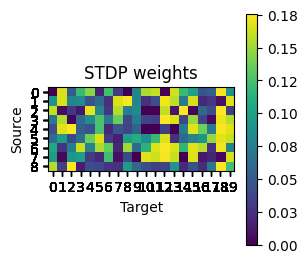

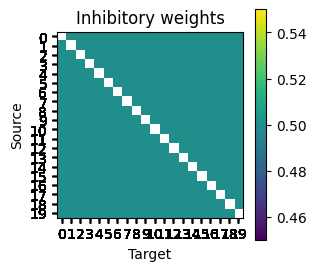

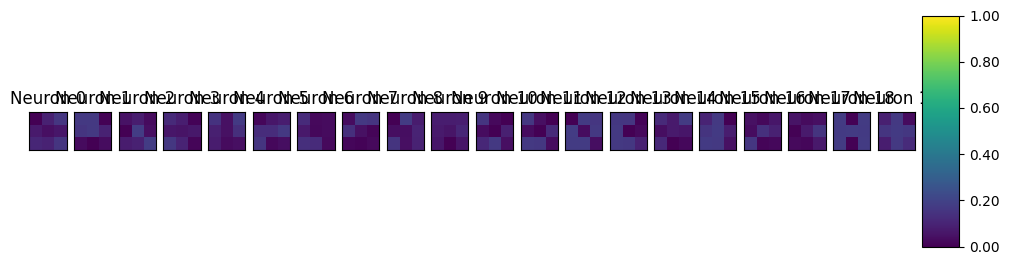

In [88]:
print(f"Input layer: {len(input_layer)} neurons")
print(f"Excitatory layer: {len(exc_layer)} neurons")
print(f"{len(stdp_synapses)} STDP synapses")
print(f"{len(inh_synapses)} inhibitory synapses")
plot_synapses(input_layer.N, exc_layer.N, stdp_synapses, "STDP weights")
plot_synapses(exc_layer.N, exc_layer.N, inh_synapses, "Inhibitory weights")
plot_input_synapses(stdp_synapses)

Training STDP weights has finished!
CPU times: user 1min 52s, sys: 811 ms, total: 1min 52s
Wall time: 1min 52s


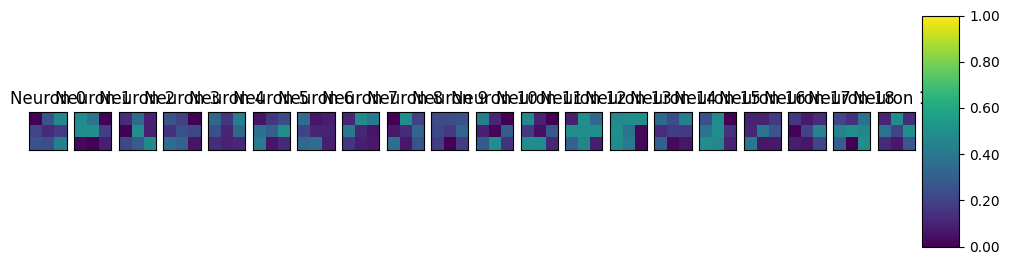

In [89]:
%%time
b2.restore()
max_rate = 60 * b2.Hz
T_img = 150*b2.ms
T_rest = 50*b2.ms
for img in X_train:
    input_layer.rates = img.ravel()*max_rate
    b2.run(T_img, report=None)
    input_layer.rates = img.ravel()*0*b2.Hz
    b2.run(T_rest, report=None)
print("Training STDP weights has finished!")
plot_input_synapses(stdp_synapses)

Training STDP weights has finished!


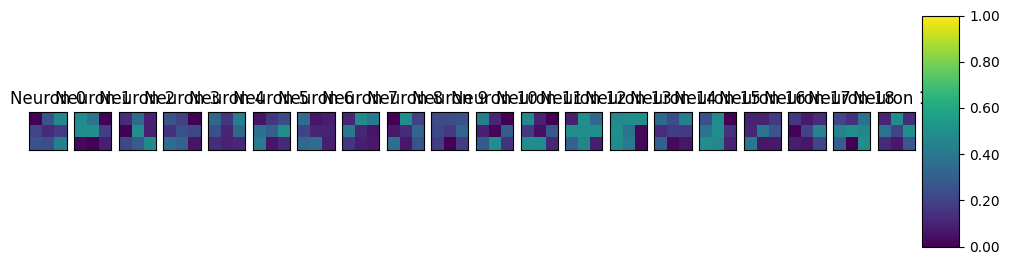

In [95]:
max_rate = 120 * b2.Hz
T_img = 150*b2.ms
T_rest = 50*b2.ms
for img in X_train:
  input_layer.rates = img.ravel()*max_rate
  b2.run(T_img, report=None)
  input_layer.rates = img.ravel()*0*b2.Hz
  b2.run(T_rest, report=None)
print("Training STDP weights has finished!")
plot_input_synapses(stdp_synapses)

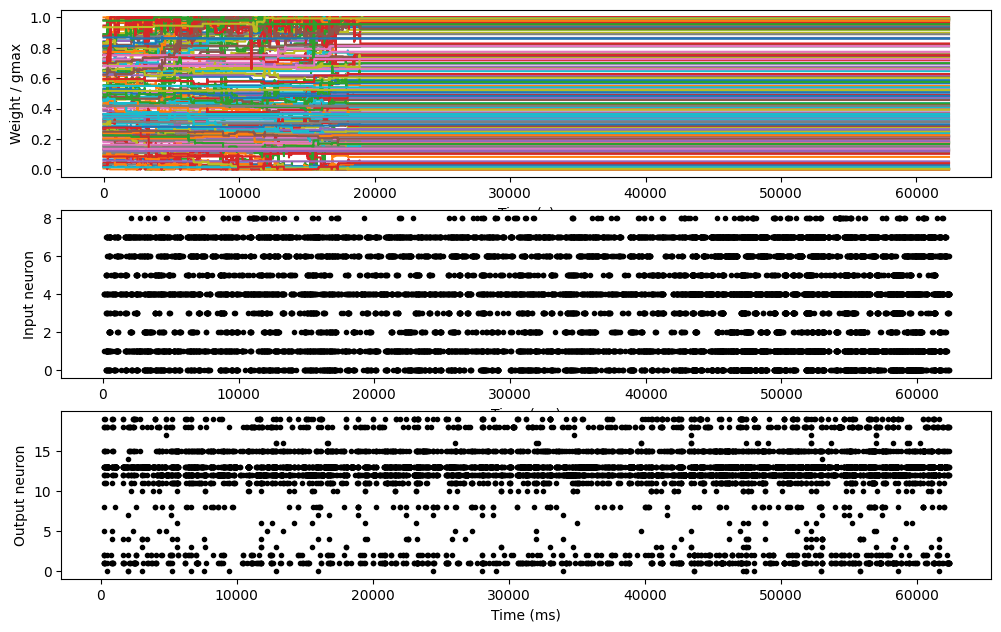

CPU times: user 9.49 s, sys: 5.72 s, total: 15.2 s
Wall time: 17.6 s


In [96]:
%%time
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(mon_stdp.t/b2.ms, mon_stdp.w.T/gmax)
plt.xlabel('Time (s)')
plt.ylabel('Weight / gmax')
plt.subplot(412)
plt.plot(mon_input.t/b2.ms, mon_input.i, '.k')
plt.xlabel('Time (ms)')
plt.ylabel('Input neuron')
#plt.yticks(range(0,len(input_rates)))
plt.subplot(413)
plt.plot(mon_exc.t/b2.ms, mon_exc.i, '.k')
plt.xlabel('Time (ms)')
plt.ylabel('Output neuron')
#plt.tight_layout()
plt.show()
#plot_synapses(input_layer.N, exc_layer.N, stdp_synapses, "STDP weights")

In [97]:
def evaluate(X):
    img_rates = np.zeros((len(X), len(exc_layer)))
    T_show = 150*b2.ms
    rate_mon = b2.SpikeMonitor(exc_layer)
    prev_count = np.zeros((len(exc_layer),))
    for i_img, img in enumerate(X):
        input_layer.rates = img.ravel()*max_rate
        b2.run(T_show, report=None)
        img_rates[i_img,:] = np.array(rate_mon.count-prev_count)
        prev_count += img_rates[i_img,:]
        input_layer.rates = img.ravel()*0*b2.Hz
        b2.run(T_rest, report=None)
        #del rate_mon
    return img_rates

[0 2 3 2 0 0 0 0 1 0 2 1 2 0 0 1 0 0 3 2]
[[0. 4. 4. ... 0. 1. 0.]
 [0. 8. 0. ... 0. 2. 3.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 1. 2. ... 0. 2. 0.]
 [0. 0. 2. ... 0. 0. 3.]
 [0. 2. 1. ... 0. 4. 0.]]
CPU times: user 1min 55s, sys: 1.29 s, total: 1min 56s
Wall time: 1min 56s


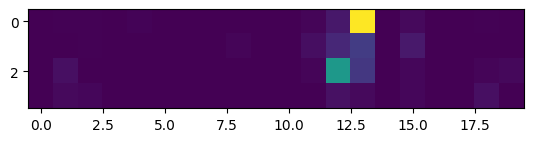

In [98]:
%%time
stdp_synapses.stdp_rate = 0
train_rates = evaluate(X_train)
nrn_class_count = np.zeros((len(patterns),len(exc_layer)))
for i_class in range(len(patterns)):
      nrn_class_count[i_class,:] = np.sum(train_rates[np.equal(y_train,i_class),:], axis=0)
plt.imshow(nrn_class_count)
neuron_class = np.argmax(nrn_class_count, axis=0)
print(neuron_class)
print(train_rates)




# 4. Сравните качество классификации по метрикам accuracy и F-measure

## 4.2

In [69]:
from sklearn.metrics import mean_squared_error

In [93]:
%%time
test_rates = evaluate(X_test)
print(test_rates[:2])

[[0. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1. 0. 1. 0. 0. 2. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]]
CPU times: user 28.4 s, sys: 178 ms, total: 28.6 s
Wall time: 28.6 s


[2. 2. 0. 0. 0. 0. 1. 2. 0. 1. 2. 0. 2. 2. 2. 1. 0. 0. 2. 0. 2. 0. 2. 0.]
[3, 3, 0, 0, 3, 1, 0, 2, 1, 1, 2, 3, 2, 3, 2, 1, 1, 1, 2, 3, 2, 0, 2, 3]
Accuracy: 0.5


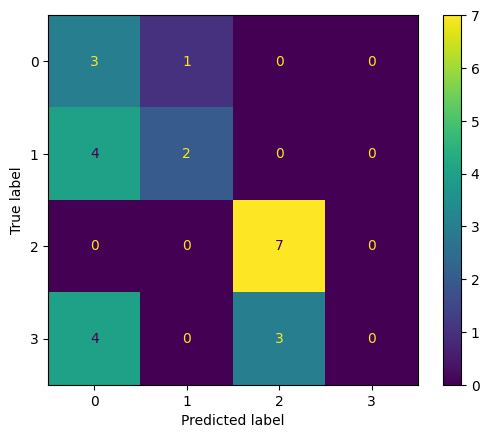

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix

def predict(rates, neuron_class):
    y = np.ones(rates.shape[0])*np.nan
    for i,x in enumerate(rates):
        y[i] = neuron_class[np.argmax(x)]
    return y

test_prediction = predict(test_rates, neuron_class)

print(test_prediction)
print(y_test)
acc = accuracy_score(y_test, test_prediction)
cm = confusion_matrix(y_test, test_prediction)
print(f"Accuracy: {acc}")
cm_display = ConfusionMatrixDisplay(cm).plot()

In [70]:
mse = mean_squared_error(y_test, test_prediction, squared=False)
print(f"MSE: {mse}")

MSE: 1.35400640077266


In [79]:
f_1 = f1_score(y_test, test_prediction,average='weighted')
print(f"f_1: {f_1}")

f_1: 0.41797385620915034


with normalization

[2. 2. 0. 0. 2. 2. 0. 2. 0. 2. 2. 2. 2. 2. 2. 2. 0. 0. 2. 2. 0. 0. 2. 2.]
[3, 3, 0, 0, 3, 1, 0, 2, 1, 1, 2, 3, 2, 3, 2, 1, 1, 1, 2, 3, 2, 0, 2, 3]
Accuracy: 0.4166666666666667
MSE: 0.8416254115301732
f_1: 0.2632850241545894


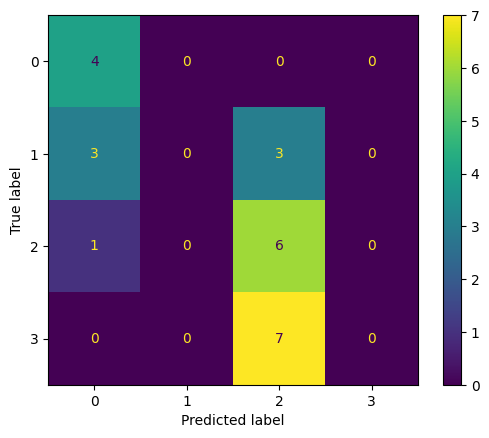

In [94]:
test_prediction = predict(test_rates, neuron_class)

print(test_prediction)
print(y_test)
acc = accuracy_score(y_test, test_prediction)
cm = confusion_matrix(y_test, test_prediction)
print(f"Accuracy: {acc}")
cm_display = ConfusionMatrixDisplay(cm).plot()
mse = mean_squared_error(y_test, test_prediction, squared=False)
print(f"MSE: {mse}")
f_1 = f1_score(y_test, test_prediction,average='weighted')
print(f"f_1: {f_1}")

with another education of neuronet

[2. 2. 0. 0. 2. 2. 0. 2. 0. 2. 2. 2. 2. 2. 2. 2. 0. 0. 2. 2. 0. 0. 2. 2.]
[3, 3, 0, 0, 3, 1, 0, 2, 1, 1, 2, 3, 2, 3, 2, 1, 1, 1, 2, 3, 2, 0, 2, 3]
Accuracy: 0.4166666666666667
MSE: 0.8416254115301732
f_1: 0.2632850241545894


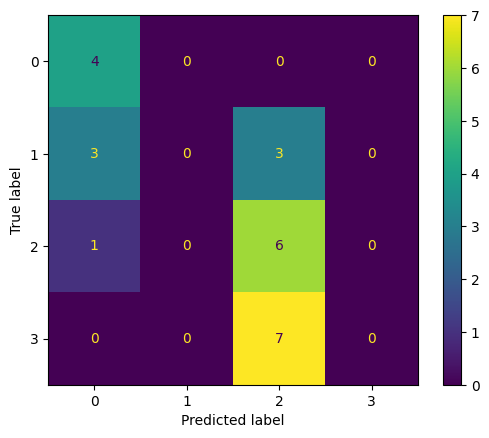

In [99]:
test_prediction = predict(test_rates, neuron_class)

print(test_prediction)
print(y_test)
acc = accuracy_score(y_test, test_prediction)
cm = confusion_matrix(y_test, test_prediction)
print(f"Accuracy: {acc}")
cm_display = ConfusionMatrixDisplay(cm).plot()
mse = mean_squared_error(y_test, test_prediction, squared=False)
print(f"MSE: {mse}")
f_1 = f1_score(y_test, test_prediction,average='weighted')
print(f"f_1: {f_1}")